# use networkx to find flow connections in the NHD
**[networkx](https://networkx.org/documentation/stable/index.html) is a library we have always had in the StreamCat python environment, here is a quick and dirty look at what it can do!**

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import rasterio
from rasterstats import zonal_stats
nhd = "E:/NHDPlusHRVFGen"             # set this to your local NHDPlusV21 dir
stream_cat_home = "C:/Users/mweber/GitProjects/StreamCat" # set this to your local StreamCat repo

### Read in NHDPlus 

- ignore some fields

* Take a look at ...[how we create numpy files](https://github.com/USEPA/StreamCat/blob/3ae0abfa704341b1dc4064455f88494db3d1ab8a/StreamCat_functions.py#L1179)

In [60]:
# %%timeit -r 1 -n 1
plusflow_out = ["NodeNumber","DeltaLevel","Direction","GapDistKm","HasGeo"]
flowline_out = ["FDate","Resolution",
                    "FlowDir","WBArea_Permanent_Identifier","FCODE","Shape_Length","Enabled","GNIS_NBR"]
flow = gpd.read_file(f"{nhd}/NHDPlusHRVFGen0105.gdb",driver='FileGDB',layer='NHDPlusFlow',
            ignore_fields=plusflow_out)
fls = gpd.read_file(f"{nhd}/NHDPlusHRVFGen0105.gdb",layer='NHDFlowline',
            ignore_fields=flowline_out) # geometry needed for plotting
cats = gpd.read_file( # this will later be used to filter out COMIDs that aren't catchments
            f"{nhd}/NHDPlusHRVFGen0105.gdb", driver='FileGDB',layer='NHDPlusCatchment_Gen',
            ignore_fields=["GridCode","SourceFC"])
flow = flow[~((flow.FromPermID == '0') | (flow.ToPermID == '0'))] # same as current numpy process
coasties = fls.loc[fls.FType == 566,"Permanent_Identifier"]        # same as current numpy process
flow = flow[~flow.FromPermID.isin(coasties)]                 # same as current numpy process
fls.to_crs("epsg:5070", inplace=True)
fls.geometry = fls.geometry.centroid

### Create a directed graph
**creating the graph is as simple as this once we have the flow table!!**

In [5]:
# %%timeit -r 1 -n 1
flow = flow.loc[:, ['FromPermID','ToPermID']]
G = nx.DiGraph()
G.add_edges_from(flow.to_records(index=False))
flow.head()

,FromPermID,ToPermID
2,151699922,151706079
4,152242894,152242891
5,152241235,152242871
8,106400358,106400404
9,106398568,106398668


### query for upstream COMIDS

* **[nx.bfs_tree](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.breadth_first_search.bfs_tree.html?highlight=bfs_tree)** -- breadth first search

In [6]:
# %%timeit -r 1 -n 1
permID = '106395858'
upstream = nx.bfs_tree(G, permID, reverse=True) # reverse means upstream for a particular PermID
print(len(upstream))
print(list(upstream)[:13])       # the first 13 PermIDs upstream in a list
print(np.array(upstream)[:13])   # or in an array
top = np.array(upstream)[-1] 

195
['106395858', '106395738', '106395720', '106395594', '106395522', '106395472', '106395434', '106395448', '106395382', '106395308', '106395184', '106395130', '106395110']
['106395858' '106395738' '106395720' '106395594' '106395522' '106395472'
 '106395434' '106395448' '106395382' '106395308' '106395184' '106395130'
 '106395110']


In [7]:
len(top)
len(upstream)

195

### looking downstream is as easy as fipping the reverse arg -- default=False
* **NOTE:** check the time diff here...looking downstream has less accumulated connections!

In [8]:
# %%timeit -r 1 -n 1
downstream = nx.bfs_tree(G, top)
print(len(downstream))
print(np.array(downstream)[:13])

113
['106390284' '106390480' '106390512' '106390520' '106390524' '106390522'
 '106390552' '106390570' '106390658' '106390708' '106390664' '106390644'
 '106390642']


### quick plot of the watershed for PermID looking upstream and downstream


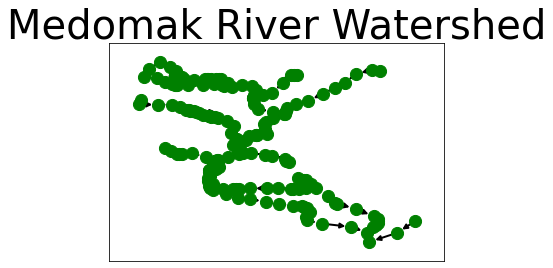

In [9]:
medomak = nx.bfs_tree(G, '106396346', reverse=True) # snake convergence: 23475172
ups = fls.loc[fls.Permanent_Identifier.isin(list(medomak))].set_index("Permanent_Identifier")
pos = ups.apply(lambda g: (g.geometry.x, g.geometry.y), axis=1).to_dict()
nx.draw_networkx(nx.DiGraph.reverse(medomak), pos, node_size=147, node_color='green',
                 font_size=18, with_labels=False, width=2)
plt.title('Medomak River Watershed', fontsize = 40)
plt.rcParams["figure.figsize"] = (40,20)
plt.show()

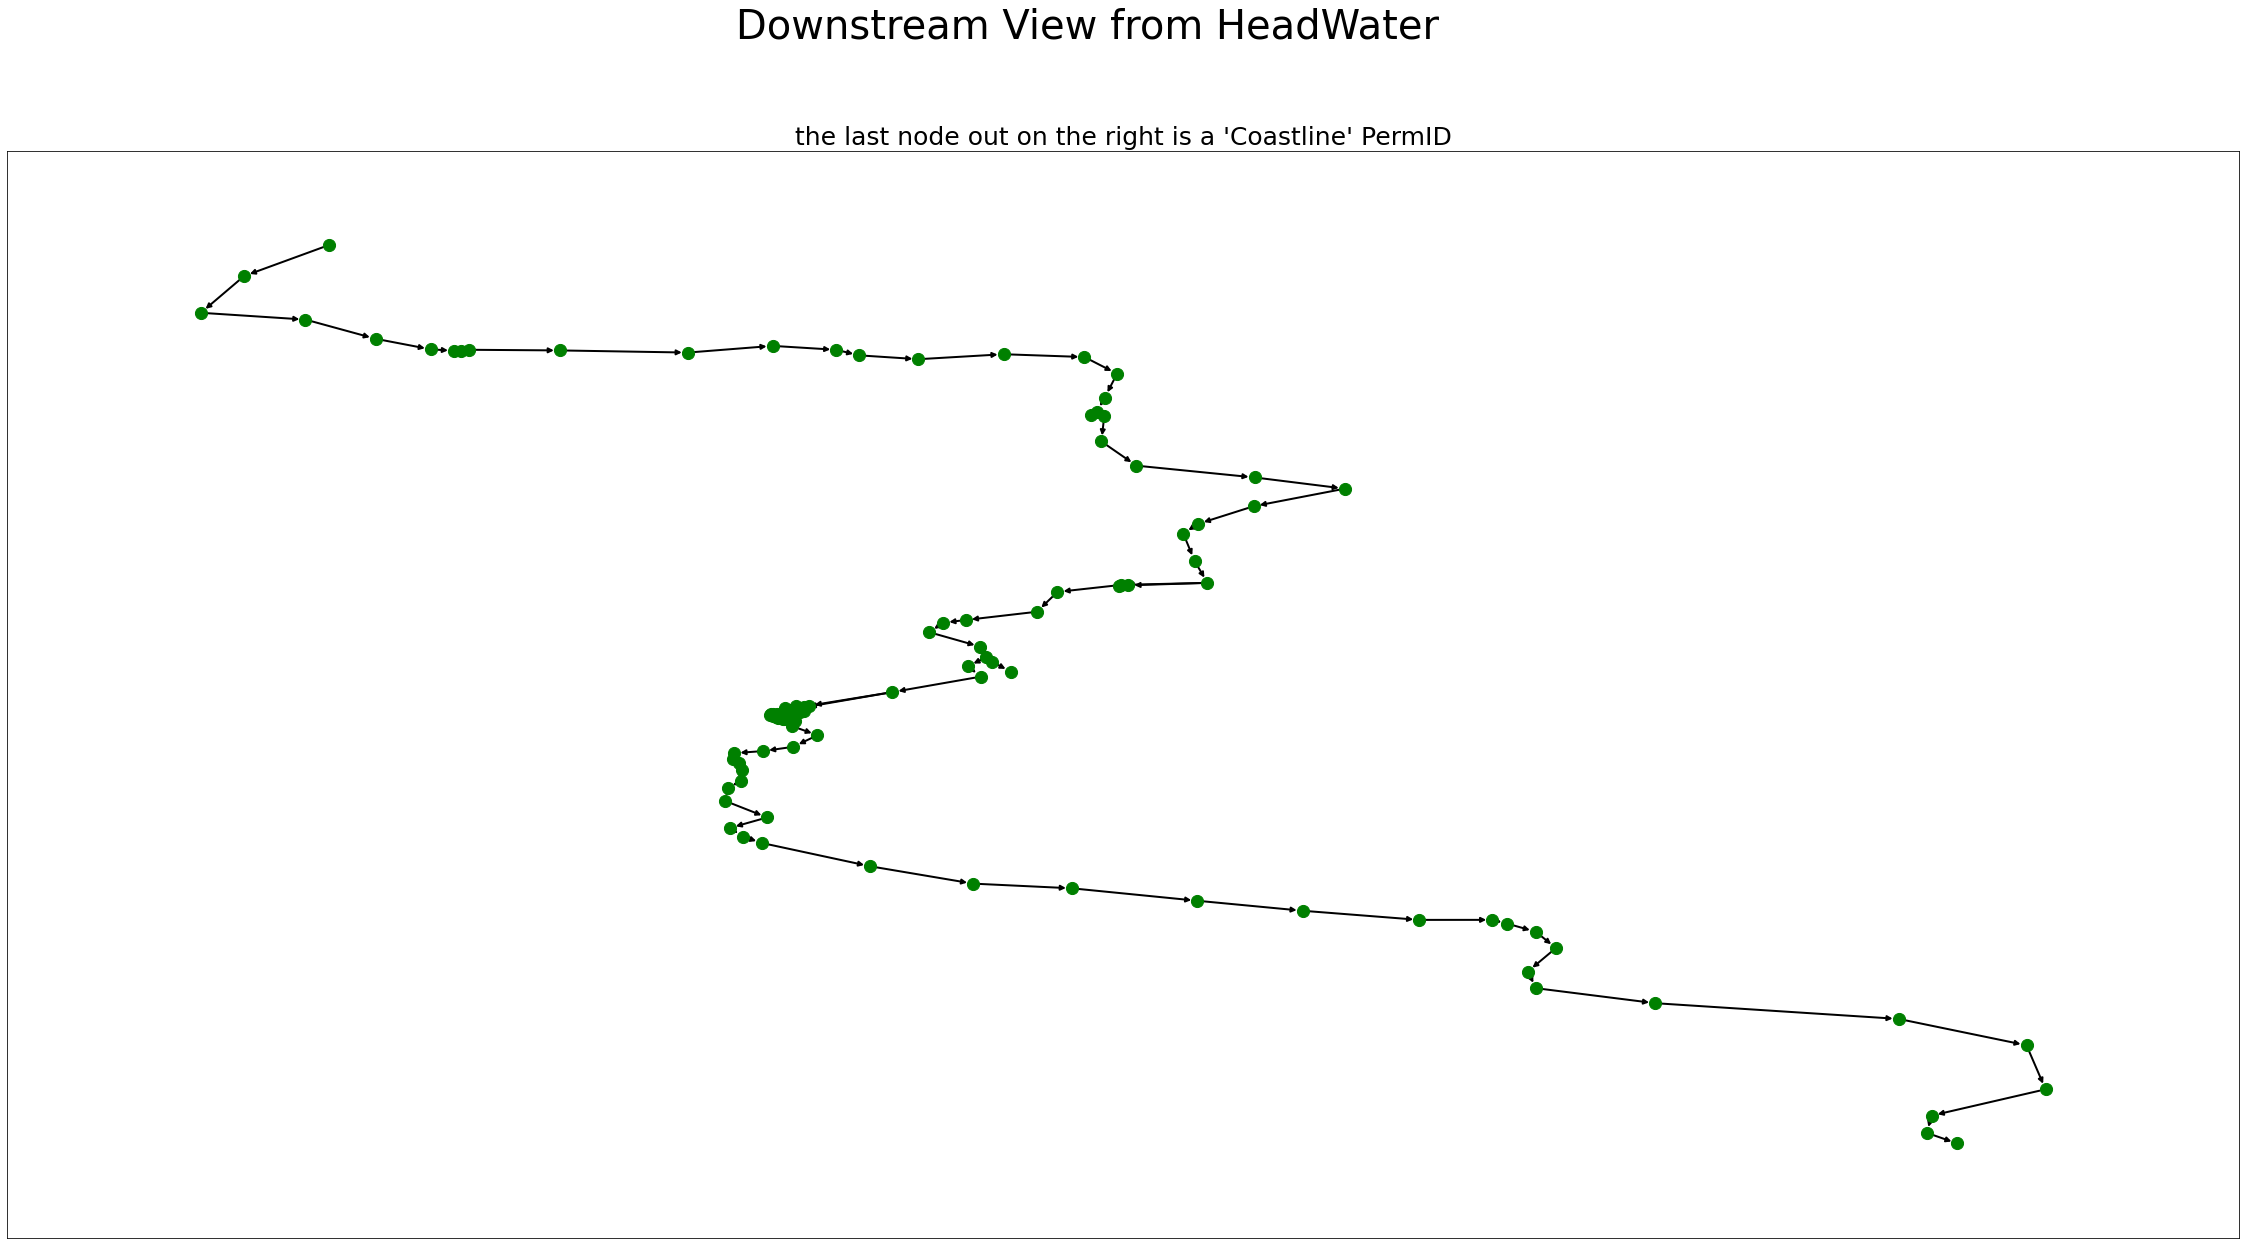

,Permanent_Identifier,GNIS_ID,GNIS_Name,LengthKM,ReachCode,FType,FCode,MainPath,InNetwork,VisibilityFilter,NHDPlusID,VPUID,geometry
4322,106396554,None,None,0.383,01050003002782,566,None,0,1,5000000,5.000200e+12,Gen,POINT (2099049.114 2631606.656)


In [10]:
medomak_down = nx.bfs_tree(G, '106390136') 
ups = fls.loc[fls.Permanent_Identifier.isin(list(medomak_down))].set_index("Permanent_Identifier")
pos = ups.apply(lambda g: (g.geometry.x, g.geometry.y), axis=1).to_dict()
nx.draw_networkx(medomak_down, pos, node_size=147, node_color='green',
                 font_size=18, with_labels=False, width=2)
plt.suptitle('Downstream View from HeadWater', fontsize = 40)
plt.title("the last node out on the right is a 'Coastline' PermID", fontsize=25)
plt.rcParams["figure.figsize"] = (40,20)
plt.show()
fls.loc[fls.Permanent_Identifier == np.array(medomak_down)[-1]]

### Run some zonal statistics

In [61]:
cats.head()

,NHDPlusID,AreaSqKm,VPUID,SHAPE_Length,SHAPE_Area,geometry
0,5.000200e+12,4.3156,Gen,0.189625,0.000483,"MULTIPOLYGON (((-69.51408 43.84561, -69.51401 ..."
1,5.000200e+12,6.5650,Gen,0.295558,0.000737,"MULTIPOLYGON (((-69.17967 44.00269, -69.18015 ..."
2,5.000200e+12,6.4839,Gen,0.229897,0.000740,"MULTIPOLYGON (((-68.27272 45.00233, -68.27275 ..."
3,5.000200e+12,4.4316,Gen,0.307985,0.000501,"MULTIPOLYGON (((-67.89108 44.47400, -67.89097 ..."
4,5.000200e+12,13.8393,Gen,0.295686,0.001585,"MULTIPOLYGON (((-67.63423 45.24109, -67.63438 ..."


In [62]:
cats['NHDPlusID'] = cats['NHDPlusID'].astype(str)
cats.head()
fls['NHDPlusID'] = fls['NHDPlusID'].astype(str)
temp=fls[['NHDPlusID','Permanent_Identifier']]
cats = cats.merge(temp, on='NHDPlusID')
# cats['row_num'] = cats.reset_index().index
cats = cats[['Permanent_Identifier','NHDPlusID','AreaSqKm','geometry']]
cats.head()

,Permanent_Identifier,NHDPlusID,AreaSqKm,geometry
0,106399278,5000200000001.0,4.3156,"MULTIPOLYGON (((-69.51408 43.84561, -69.51401 ..."
1,151711606,5000200000003.0,6.5650,"MULTIPOLYGON (((-69.17967 44.00269, -69.18015 ..."
2,151699922,5000200000006.0,6.4839,"MULTIPOLYGON (((-68.27272 45.00233, -68.27275 ..."
3,151711668,5000200000007.0,4.4316,"MULTIPOLYGON (((-67.89108 44.47400, -67.89097 ..."
4,152242894,5000200000008.0,13.8393,"MULTIPOLYGON (((-67.63423 45.24109, -67.63438 ..."


In [63]:
cats.dtypes

Permanent_Identifier      object
NHDPlusID                 object
AreaSqKm                 float64
geometry                geometry
dtype: object

In [64]:
# cats['row_num'] = cats['row_num'].astype(int)
cats['NHDPlusID'] = cats['NHDPlusID'].astype(str)
cats['Permanent_Identifier'] = cats['Permanent_Identifier'].astype(str)

In [74]:
clay = 'O:/PRIV/CPHEA/PESD/COR/CORFILES/Geospatial_Library_Projects/StreamCat/LandscapeRasters/QAComplete/clay.tif'
cats = cats.to_crs(5070)
clay_stats = zonal_stats(cats, clay, all_touched=True,geojson_out=True, stats="count mean sum nodata")
clay_stats = gpd.GeoDataFrame.from_features(clay_stats)
clay_stats['clay'] = clay_stats['mean'].apply(lambda x: x*0.01)
clay_stats.head()

,geometry,AreaSqKm,NHDPlusID,Permanent_Identifier,mean,count,sum,nodata,clay
0,"MULTIPOLYGON (((2094075.000 2610815.000, 20940...",4.3156,5000200000001.0,106399278,736.000000,3613,2659168.0,1475.0,7.360000
1,"MULTIPOLYGON (((2114935.000 2635055.000, 21148...",6.5650,5000200000003.0,151711606,736.000000,5021,3695456.0,2732.0,7.360000
2,"MULTIPOLYGON (((2152415.000 2762225.000, 21524...",6.4839,5000200000006.0,151699922,687.126108,7557,5192612.0,0.0,6.871261
3,"MULTIPOLYGON (((2198325.000 2714655.000, 21983...",4.4316,5000200000007.0,151711668,699.284700,2536,1773386.0,2887.0,6.992847
4,"MULTIPOLYGON (((2192705.000 2802235.000, 21927...",13.8393,5000200000008.0,152242894,1306.000000,13120,17134720.0,2729.0,13.060000


### each node can have attrs! a dict associated with every COMID

In [85]:
# %%timeit -r 1 -n 1
# z = np.unique(np.concatenate([flow.ToPermID.values, flow.FromPermID.values]))
# for tt in clay_stats.itertuples():
#     if tt.Permanent_Identifier in z:
#         G.nodes[tt.Permanent_Identifier]["clay"] = tt.clay  # cleaner/quicker way for this???
# same just displaying from zonal stats table but can join to nodes as well and creates a dictionary
print('ClayCat is ' + str(clay_stats.loc[clay_stats['Permanent_Identifier'] == '106390136', 'clay'].item()))
print('ClayCat is ' + str(G.nodes['106390136']['clay']))

ClayCat is 6.11
ClayCat is 6.11


### sum area for the watershed using the attrs!!!
* **NOTE:** `upstream` here is itself a Graph object, but the attrs don't come along with the `nx.bfs_tree` search that we do, so we can subset the graph

In [97]:
# %%timeit -r 1 -n 1
H = G.subgraph(list(upstream))
# np.array(list(nx.get_node_attributes(H, "clay").values())).mean()
clay_ws = np.array(list(nx.get_node_attributes(H, "clay").values())).mean()
print('ClayWs is ' + '%.2f'%(clay_ws))

ClayWs is 12.93


## Example for Columbia - multiple HUC4 regions
Read in NHDPlus HR

- ignore some fields

* Take a look at ...[how we create numpy files](https://github.com/USEPA/StreamCat/blob/3ae0abfa704341b1dc4064455f88494db3d1ab8a/StreamCat_functions.py#L1179)

In [3]:
nhd = "E:/NHDPlusHR" 
import pandas as pd
plusflow_out = ["NodeNumber","DeltaLevel","Direction","GapDistKm","HasGeo"]
flowline_out = ["FDate","Resolution",
                    "FlowDir","WBArea_Permanent_Identifier","FCODE","Shape_Length","Enabled","GNIS_NBR"]
flow1 = gpd.read_file(f"{nhd}/NHDPLUS_H_1707_HU4_GDB.gdb",driver='FileGDB',layer='NHDPlusFlow',
            ignore_fields=plusflow_out)
fls1 = gpd.read_file(f"{nhd}/NHDPLUS_H_1707_HU4_GDB.gdb",layer='NHDFlowline',
            ignore_fields=flowline_out) # geometry needed for plotting
cats1 = gpd.read_file( # this will later be used to filter out COMIDs that aren't catchments
            f"{nhd}/NHDPLUS_H_1707_HU4_GDB.gdb", driver='FileGDB',layer='NHDPlusCatchment',
            ignore_fields=["GridCode","SourceFC"])
flow2 = gpd.read_file(f"{nhd}/NHDPLUS_H_1708_HU4_GDB.gdb",driver='FileGDB',layer='NHDPlusFlow',
            ignore_fields=plusflow_out)
fls2 = gpd.read_file(f"{nhd}/NHDPLUS_H_1708_HU4_GDB.gdb",layer='NHDFlowline',
            ignore_fields=flowline_out) # geometry needed for plotting
cats2 = gpd.read_file( # this will later be used to filter out COMIDs that aren't catchments
            f"{nhd}/NHDPLUS_H_1707_HU4_GDB.gdb", driver='FileGDB',layer='NHDPlusCatchment',
            ignore_fields=["GridCode","SourceFC"])
flow = pd.concat([flow1,flow2])
fls = pd.concat([fls1,fls2])
cats = pd.concat([cats1,cats2])
del flow1
del flow2
del fls1
del fls2
del cats1
del cats2
flow = flow[~((flow.FromPermID == '0') | (flow.ToPermID == '0'))] # same as current numpy process
coasties = fls.loc[fls.FType == 566,"Permanent_Identifier"]        # same as current numpy process
flow = flow[~flow.FromPermID.isin(coasties)]                 # same as current numpy process
fls.to_crs("epsg:5070", inplace=True)
fls.geometry = fls.geometry.centroid

### Create a directed graph
**creating the graph is as simple as this once we have the flow table!!**

In [40]:
# %%timeit -r 1 -n 1
flow = flow.loc[:, ['FromPermID','ToPermID']]
flow = flow[flow.FromPermID.isin(fls.Permanent_Identifier)]
flow = flow[flow.ToPermID.isin(fls.Permanent_Identifier)]
G = nx.DiGraph()
G.add_edges_from(flow.to_records(index=False))
flow.head()

,FromPermID,ToPermID
28071,167672337,165121479
28072,149932133,149954830
28073,149932134,149954834
105124,150801821,150801885
105125,150813623,150813620


### query for upstream COMIDS

* **[nx.bfs_tree](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.breadth_first_search.bfs_tree.html?highlight=bfs_tree)** -- breadth first search

In [23]:
flow.dtypes
'129407443' in flow.ToPermID.values

True

In [41]:
# %%timeit -r 1 -n 1
permID = '129407443'
upstream = nx.bfs_tree(G, permID, reverse=True) # reverse means upstream for a particular PermID
print(len(upstream))
print(list(upstream)[:13])       # the first 13 PermIDs upstream in a list
print(np.array(upstream)[:13])   # or in an array
top = np.array(upstream)[-1] 

421648
['129407443', '164359777', '164359775', '129407444', '164359776', '164359779', '164348256', '164359724', '164359725', '164359778', '164348270', '164349466', '164359723']
['129407443' '164359777' '164359775' '129407444' '164359776' '164359779'
 '164348256' '164359724' '164359725' '164359778' '164348270' '164349466'
 '164359723']


### looking downstream is as easy as fipping the reverse arg -- default=False
* **NOTE:** check the time diff here...looking downstream has less accumulated connections!

In [42]:
# %%timeit -r 1 -n 1
downstream = nx.bfs_tree(G, top)
print(len(downstream))
print(np.array(downstream)[:13])

3052
['113007816' '113007812' '160251740' '160252036' '160252037' '160251803'
 '160251849' '113007552' '160251870' '160251993' '113007408' '113007378'
 '160251888']


In [ ]:
### quick plot of the watershed for section of Columbia River looking upstream and downstream

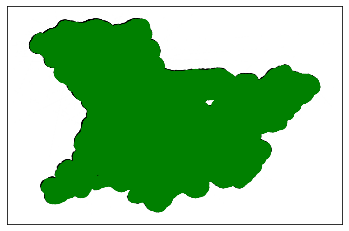

In [43]:
columbia = nx.bfs_tree(G, '129407443', reverse=True)
ups = fls.loc[fls.Permanent_Identifier.isin(list(columbia))].set_index("Permanent_Identifier")
ups.head()
pos = ups.apply(lambda g: (g.geometry.x, g.geometry.y), axis=1).to_dict()
nx.draw_networkx(nx.DiGraph.reverse(columbia), pos, node_size=147, node_color='green',
                 font_size=18, with_labels=False, width=2)
# plt.title('Columbia River Upstream', fontsize = 40)
# plt.rcParams["figure.figsize"] = (40,20)
# plt.show()

In [36]:
flow.loc[flow.FromPermID=='164345441']
fls.loc[fls.Permanent_Identifier=='164345441']

,Permanent_Identifier,GNIS_ID,GNIS_Name,LengthKM,ReachCode,FType,FCode,MainPath,InNetwork,VisibilityFilter,NHDPlusID,VPUID,geometry


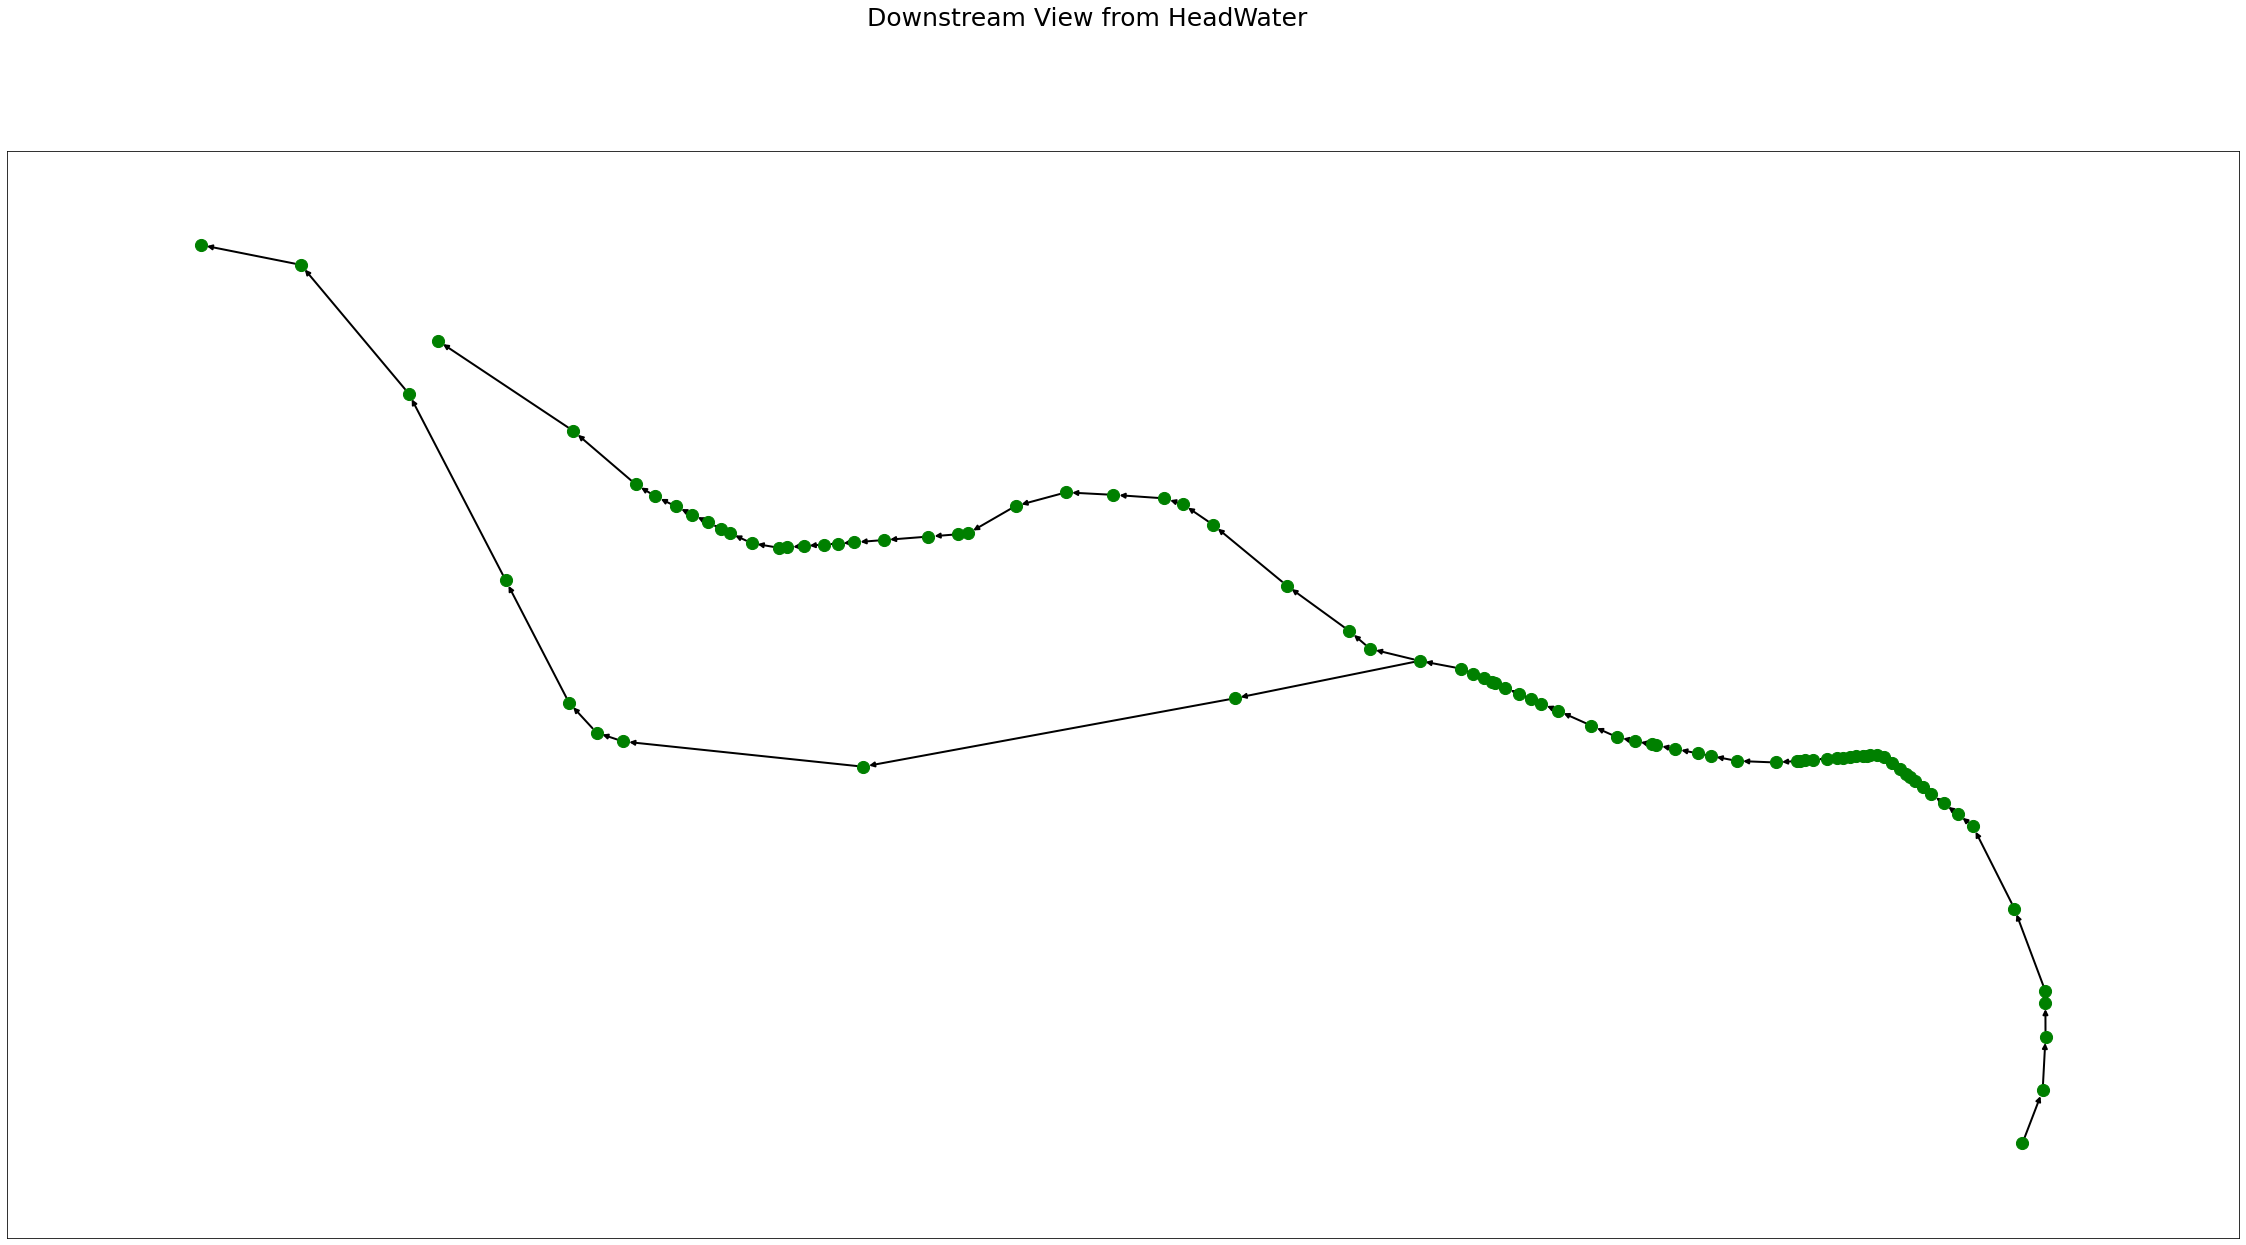

,Permanent_Identifier,GNIS_ID,GNIS_Name,LengthKM,ReachCode,FType,FCode,MainPath,InNetwork,VisibilityFilter,NHDPlusID,VPUID,geometry
172307,147682582,01140014,Columbia River,4.354,17080006000980,558,None,0,1,0,5.500030e+13,1708,POINT (-2131996.048 2901157.710)


In [45]:
columbia_down = nx.bfs_tree(G, '129407443') 
ups = fls.loc[fls.Permanent_Identifier.isin(list(columbia_down))].set_index("Permanent_Identifier")
pos = ups.apply(lambda g: (g.geometry.x, g.geometry.y), axis=1).to_dict()
nx.draw_networkx(columbia_down, pos, node_size=147, node_color='green',
                 font_size=18, with_labels=False, width=2)
plt.suptitle('Downstream View from HeadWater', fontsize = 25)
plt.rcParams["figure.figsize"] = (40,20)
plt.show()
fls.loc[fls.Permanent_Identifier == np.array(columbia_down)[-1]]

### Run some zonal statistics

In [4]:
cats.head()

,NHDPlusID,AreaSqKm,VPUID,SHAPE_Length,SHAPE_Area,geometry
0,5.500040e+13,1.4119,1707,0.083003,0.000163,"MULTIPOLYGON (((-121.89216 45.66997, -121.8922..."
1,5.500040e+13,0.0208,1707,0.015304,0.000002,"MULTIPOLYGON (((-121.31994 45.77734, -121.3203..."
2,5.500040e+13,0.7578,1707,0.071280,0.000088,"MULTIPOLYGON (((-121.26562 45.79107, -121.2655..."
3,5.500040e+13,0.0492,1707,0.017025,0.000006,"MULTIPOLYGON (((-121.54939 45.82354, -121.5494..."
4,5.500040e+13,0.2677,1707,0.044346,0.000031,"MULTIPOLYGON (((-121.82195 45.74904, -121.8220..."


In [5]:
cats['NHDPlusID'] = cats['NHDPlusID'].astype(str)
cats.head()
fls['NHDPlusID'] = fls['NHDPlusID'].astype(str)
temp=fls[['NHDPlusID','Permanent_Identifier']]
cats = cats.merge(temp, on='NHDPlusID')
# cats['row_num'] = cats.reset_index().index
cats = cats[['Permanent_Identifier','NHDPlusID','AreaSqKm','geometry']]
cats.head()

,Permanent_Identifier,NHDPlusID,AreaSqKm,geometry
0,150813811,55000400206548.0,1.4119,"MULTIPOLYGON (((-121.89216 45.66997, -121.8922..."
1,150813811,55000400206548.0,1.4119,"MULTIPOLYGON (((-121.89216 45.66997, -121.8922..."
2,147210627,55000400039342.0,0.0208,"MULTIPOLYGON (((-121.31994 45.77734, -121.3203..."
3,147210627,55000400039342.0,0.0208,"MULTIPOLYGON (((-121.31994 45.77734, -121.3203..."
4,147204283,55000400142361.0,0.7578,"MULTIPOLYGON (((-121.26562 45.79107, -121.2655..."


In [6]:
cats.dtypes

Permanent_Identifier      object
NHDPlusID                 object
AreaSqKm                 float64
geometry                geometry
dtype: object

In [7]:
# cats['row_num'] = cats['row_num'].astype(int)
cats['NHDPlusID'] = cats['NHDPlusID'].astype(str)
cats['Permanent_Identifier'] = cats['Permanent_Identifier'].astype(str)

In [ ]:
clay = 'E:/clay.tif'
cats = cats.to_crs(5070)
clay_stats = zonal_stats(cats, clay, all_touched=True,geojson_out=True, stats="count mean sum nodata")
clay_stats = gpd.GeoDataFrame.from_features(clay_stats)
clay_stats['clay'] = clay_stats['mean'].apply(lambda x: x*0.01)
clay_stats.head()

### each node can have attrs! a dict associated with every COMID

In [85]:
# %%timeit -r 1 -n 1
# z = np.unique(np.concatenate([flow.ToPermID.values, flow.FromPermID.values]))
# for tt in clay_stats.itertuples():
#     if tt.Permanent_Identifier in z:
#         G.nodes[tt.Permanent_Identifier]["clay"] = tt.clay  # cleaner/quicker way for this???
# same just displaying from zonal stats table but can join to nodes as well and creates a dictionary
print('ClayCat is ' + str(clay_stats.loc[clay_stats['Permanent_Identifier'] == '106390136', 'clay'].item()))
print('ClayCat is ' + str(G.nodes['106390136']['clay']))

ClayCat is 6.11
ClayCat is 6.11


### sum area for the watershed using the attrs!!!
* **NOTE:** `upstream` here is itself a Graph object, but the attrs don't come along with the `nx.bfs_tree` search that we do, so we can subset the graph

In [97]:
# %%timeit -r 1 -n 1
H = G.subgraph(list(upstream))
# np.array(list(nx.get_node_attributes(H, "clay").values())).mean()
clay_ws = np.array(list(nx.get_node_attributes(H, "clay").values())).mean()
print('ClayWs is ' + '%.2f'%(clay_ws))

ClayWs is 12.93
